<a href="https://colab.research.google.com/github/chrisrichardson/fenics-tutorial/blob/main/poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install FEniCSx packages
try:
    import dolfinx
except ImportError:
    !wget -q -nc "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh" >& err.log
    import dolfinx

## Import all the required modules

In [2]:
from mpi4py import MPI
import numpy as np

# Plotting support
import pyvista
pyvista.global_theme.jupyter_backend = 'static'
pyvista.global_theme.notebook = True

# FEniCS DSL
import ufl
from ufl import grad, dx, TestFunction, TrialFunction, inner

# FEniCS main package
from dolfinx.plot import vtk_mesh
from dolfinx.mesh import create_unit_square, locate_entities_boundary, CellType
from dolfinx.fem import functionspace, dirichletbc, locate_dofs_topological
from dolfinx.fem import form, Constant, Function, Expression, assemble_scalar
from dolfinx.fem import assemble_matrix, assemble_vector, apply_lifting

# Interface to Petsc linear algebra
from dolfinx.fem.petsc import LinearProblem

In [3]:
# Create a unit square with 40 cells in each direction (default triangle cells)
mesh = create_unit_square(MPI.COMM_WORLD, 40, 40)

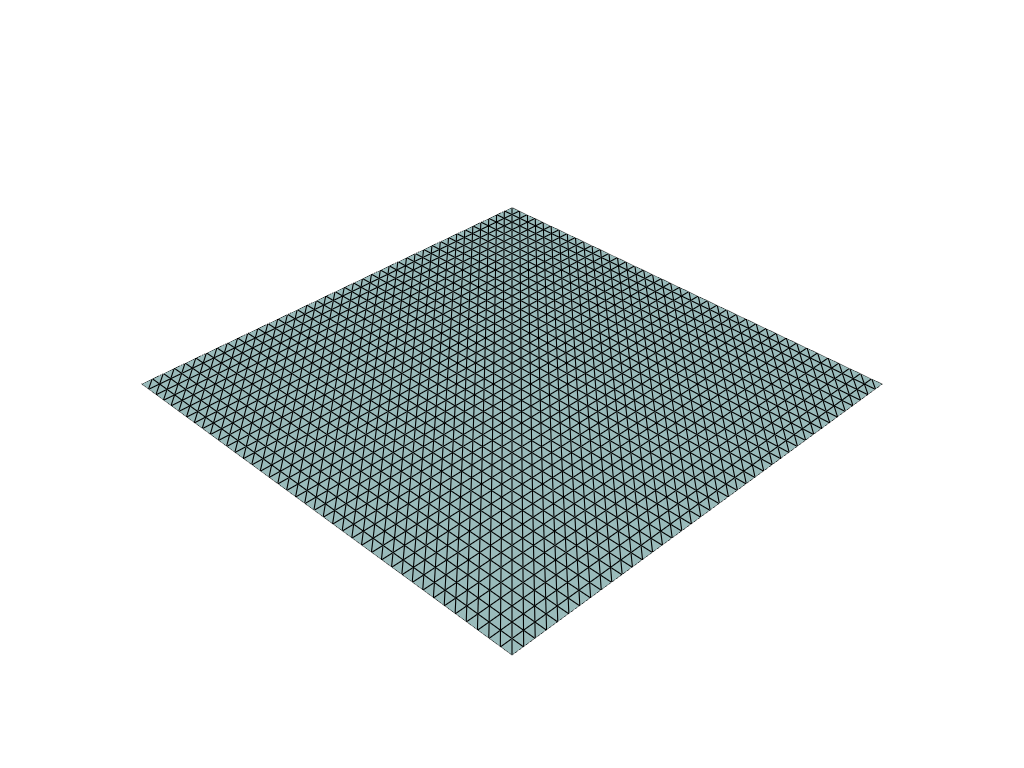

In [39]:
# Visualise mesh
plotter = pyvista.Plotter()
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh));
plotter.add_mesh(grid, show_edges=True)
plotter.show()

In [40]:
# FEniCS definition of the space to solve in, in this case "P1".
V = functionspace(mesh, ("Lagrange", 1))
u, v = TrialFunction(V), TestFunction(V)

# Weak-form definition of Poisson equation
# Left hand side
a = inner(grad(u), grad(v)) * dx

# Right hand side
x = ufl.SpatialCoordinate(mesh)
f = ufl.sin(x[0] * 6 * np.pi) * ufl.sin(x[1] * 2 * np.pi)
L = inner(f, v) * dx

# Find edges of the mesh, and associated degrees of freedom (dofs)
facets = locate_entities_boundary(mesh, dim=1,
    marker=lambda x: np.isclose(x[0], 0.0) | np.isclose(x[1], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 1.0))
dofs = locate_dofs_topological(V, 1, facets)

# Fix values at dofs on boundary
w = Function(V)
# Set to zero
w.x.array[:] = 0.0
# Alternatively, use a function to set the values
# w.interpolate(lambda x: 0.01*np.sin(12*x[1]))
bc = dirichletbc(w, dofs)

In [41]:
# Use PETSc to solve the A.x=b linear algebra problem
problem = LinearProblem(a, L, bcs=[bc],
    petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()


In [42]:
# Print out the solution values
print(uh.x.array)

[0. 0. 0. ... 0. 0. 0.]


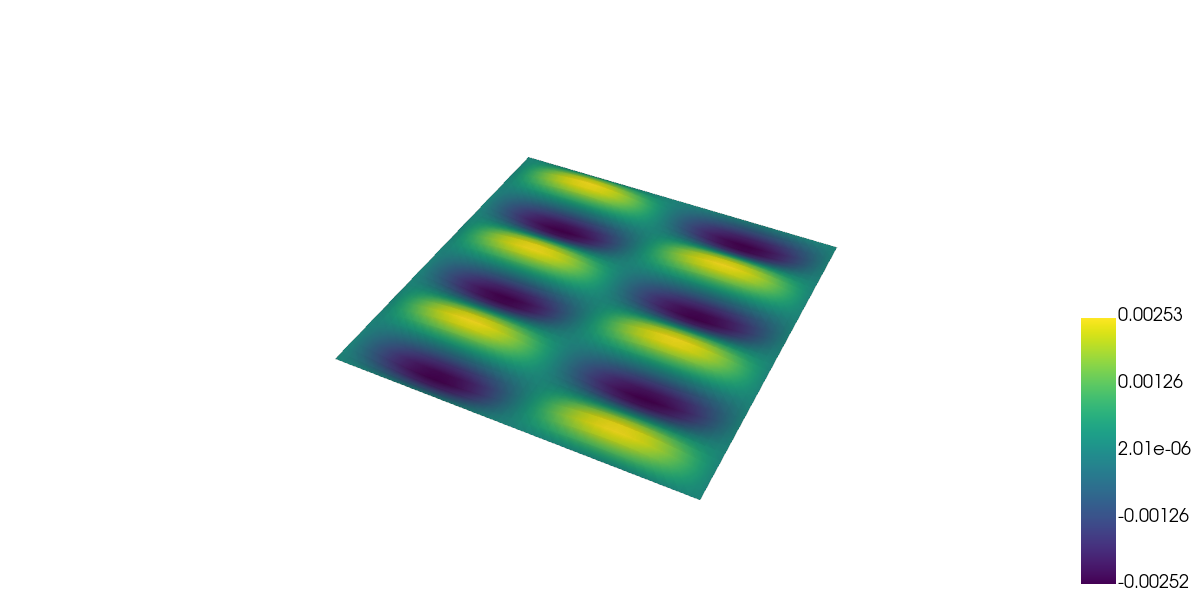

In [43]:
# Plot the solution values on the mesh

plotter = pyvista.Plotter(window_size=([1200,600]))
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh));
grid.point_data["u"] = uh.x.array[:]
grid.set_active_scalars("u")
grid.warp_by_scalar("u", factor=12.0, inplace=True)
plotter.add_mesh(grid, show_edges=False)
plotter.remove_scalar_bar()
plotter.add_scalar_bar(vertical=True)
plotter.camera.position = (2.5, 1.5, 2)
plotter.camera.focal_point = (0.5, 0.5, 0.0)
# plotter.camera.up = (0.0, 0.0, 1.0)
# plotter.camera.zoom(1.0)

plotter.show()


In [17]:
# You can take a look at the kernel generated code here

!cat $HOME/.cache/fenics/libffcx_forms*.c
